# Setup

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from ssm import *
import pandas as pd
import os
import matplotlib.patches as mpatches
npr.seed(0)

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_dir = '/Users/colineleteurtre/Library/CloudStorage/OneDrive-Personnel/Documents/cours/EPFL/MA2/projet_sem/visual-perception'
root_dir = os.getcwd()

### what to do
save_data = True

## Initialize GLM-HMM

## Check that the model is working

In [219]:
n = 9000 #number of trials
trials = np.arange(1, n +1)
responses = np.zeros(n, dtype=int)
stimulus = np.random.choice([-1, 1], size=n)

orientation_perc_external = 0.70
prev_resp_perc_external = 1 - orientation_perc_external
orientation_perc_internal = 0.10
prev_resp_perc_internal = 1 - orientation_perc_internal

breakpoints = np.sort(np.random.choice(range(1, n), size=19, replace=False))
breakpoints = np.concatenate(([0], breakpoints, [n]))
intervals = [trials[breakpoints[i]:breakpoints[i+1]] for i in range(len(breakpoints) - 1)]

odd_length = 0
even_length = 0

for i, interval in enumerate(intervals):
    #print(f"Interval {i + 1} (size {len(interval)}): {interval}")
    interval_length = len(interval)
    if (i+1)%2 == 0:                #i+1 even -> external state
        even_length += interval_length
        for j in range(len(interval)):
            idx = interval[j] - 1 
            if np.random.rand() < orientation_perc_external:
                responses[idx] = stimulus[idx]
            else:
                if idx > 0:
                    responses[idx] = responses[idx - 1]
                else:
                    responses[idx] = stimulus[idx]  
    else:                           #i+1 odd -> internal state
        odd_length += interval_length
        for j in range(len(interval)):
            idx = interval[j] - 1  
            if np.random.rand() < orientation_perc_internal:
                responses[idx] = stimulus[idx]
            else:
                if idx > 0:
                    responses[idx] = responses[idx - 1]
                else:
                    responses[idx] = stimulus[idx] 

prev_resp = np.zeros_like(responses)  # Initialize an array of zeros
prev_resp[1:] = responses[:-1] 
responses[responses == -1] = 0

total_length = odd_length + even_length
fraction_odd = odd_length / total_length
fraction_even = even_length / total_length
print(f"Fraction of odd intervals (internal): {fraction_odd:.2f} versus even intervals (external): {fraction_even:.2f}")


Fraction of odd intervals (internal): 0.64 versus even intervals (external): 0.36


In [267]:
interval_data_64 = pd.DataFrame({
    'Breakpoints': breakpoints[:-1],
    'Intervals': intervals
})
interval_data_64.to_csv(root_dir + f'/test_model_intervals_{fraction_odd * 100:.0f}.csv', index=False)

In [ ]:
final_df = pd.DataFrame({
    'ID': np.ones(n, dtype=int),         
    'block': np.ones(n, dtype=int),      
    'theta': stimulus,                   
    'prev_resp': prev_resp,              
    'resp': responses,                   
    'correct': np.zeros(n, dtype=int)    
})

final_df['correct'] = np.where((final_df['theta'] == -1) & (final_df['resp'] == 0), 1,
                np.where((final_df['theta'] == -1) & (final_df['resp'] == 1), 0,
                np.where((final_df['theta'] ==1)  & (final_df['resp'] == 1), 1, 0)))

final_df.to_csv(root_dir + f'/Full_Data/Full_Data_test_model_{fraction_odd * 100:.0f}.csv', index=False)

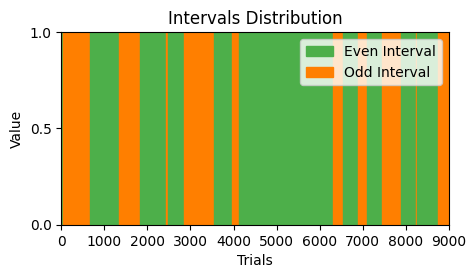

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2.5))

cols = ['#ff7f00', '#4daf4a', '#377eb8',  '#8B0000', '#000000']

for i, interval in enumerate(intervals):
    start = breakpoints[i]
    end = breakpoints[i + 1]

    if (i+1) % 2 == 0:
        color = cols[0]
    else:
        color = cols[1]
    
    ax.add_patch(plt.Rectangle((start, 0), end - start, 1, color=color))

even_patch = mpatches.Patch(color= cols[1], label='Even Interval')
odd_patch = mpatches.Patch(color= cols[0], label='Odd Interval')
ax.legend(handles=[even_patch, odd_patch], loc='upper right')

ax.set_xlim(0, 9000)  
ax.set_ylim(0, 1)    
plt.yticks([0, 0.5, 1], fontsize = 10)
ax.set_xlabel('Trials')
ax.set_ylabel('Value')
ax.set_title('Intervals Distribution')
plt.savefig(root_dir + '/plots/test_model/intervals_distribution_orientation.png', bbox_inches="tight")

plt.show()

## Load and prepare inputs

In [3]:
### read and data 
dfs = []
#columns_to_keep = ['theta', 'resp', 'block', 'correct']
columns_to_keep = ['theta', 'resp', 'block', 'correct', 'isi_ms']

n = 6 #number of participants 

for i in range (n):
    df = pd.read_csv(f'{root_dir}/Data/00{i+1}/00{i+1}.csv')[columns_to_keep]
    df['ID'] = i+1  
    #df.loc[df['isi_ms'] < 300, 'resp'] = 0
    df['prev_resp'] = df.groupby('block')['resp'].shift(1, fill_value=0)
    #df = df[df['isi_ms'] >= 300]
    dfs.append(df)

final_df = pd.concat(dfs, ignore_index=True)
final_df = final_df[['ID', 'block', 'theta', 'prev_resp', 'resp', 'correct', 'isi_ms']]
final_df['resp'] = final_df['resp'].replace(-1, 0)
final_df['theta'] = final_df['theta'].replace(-45, -1)
final_df['theta'] = final_df['theta'].replace(45, 1)
final_df.to_csv(root_dir + '/Full_Data/Full_Data.csv', index=False)

In [170]:
#isi,block,trial,isi_ms,isi_frames,theta,log_cnt,resp,rt,stim_duration,blank_duration,cnt,correct
#33,1,1,640,64,-45,-1.8546873026985,-1,0.546695,0.0482276000002457,0.645238199999767,0.0139737412527265,1

In [4]:
summary = {}
for col in final_df.columns:
    unique_values = final_df[col].unique()
    summary[col] = unique_values.tolist()
for col, types in summary.items():
    print(f"{col}: {types}")

ID: [1, 2, 3, 4, 5, 6]
block: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
theta: [-1, 1]
prev_resp: [0, -1, 1]
resp: [0, 1]
correct: [1, 0]
isi_ms: [640, 100, 920, 620, 440, 580, 680, 820, 460, 1000, 360, 800, 280, 880, 760, 40, 240, 300, 60, 600, 980, 540, 560, 780, 20, 220, 340, 660, 160, 960, 420, 0, 740, 400, 180, 80, 700, 140, 320, 860, 260, 720, 120, 380, 900, 840, 940, 200, 500, 520, 480]


#### Plot Mean Correctness versus ID

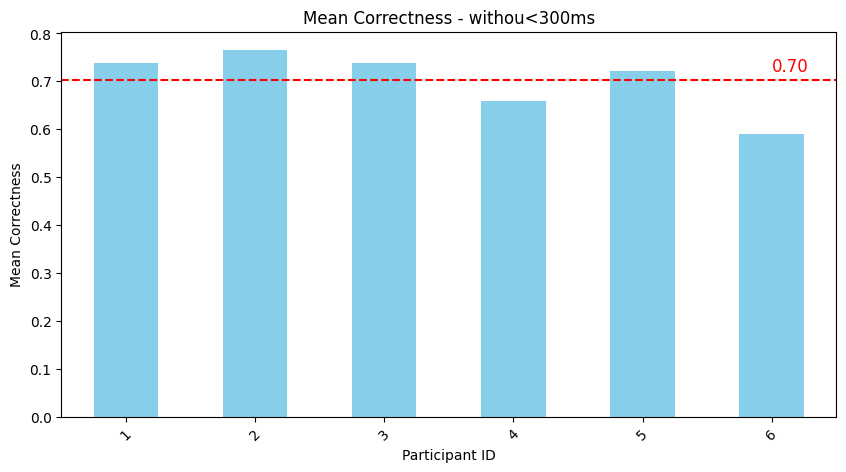

In [5]:
# Group by ID and calculate the mean correctness
mean_correctness = final_df.groupby("ID")["correct"].mean()

# Calculate the mean of the means
mean_of_means = mean_correctness.mean()

# Plot the means of correctness for each participant
plt.figure(figsize=(10, 5))
mean_correctness.plot(kind="bar", color="skyblue")
plt.axhline(mean_of_means, color="red", linestyle="--", label=f"Mean of Means: {mean_of_means:.2f}")
plt.text(len(mean_correctness) - 1, mean_of_means + 0.02, f"{mean_of_means:.2f}", color="red", fontsize=12)

#plt.title("Mean Correctness per Participant (ID) - Our Data")
plt.title("Mean Correctness - withou<300ms")
plt.xlabel("Participant ID")
plt.ylabel("Mean Correctness")
plt.xticks(rotation=45)
plt.savefig(root_dir + '/plots/without300ms/mean_correctness_per_participant.png', bbox_inches="tight")
plt.show()

#### Plot Mean Correctness versus isi_ms

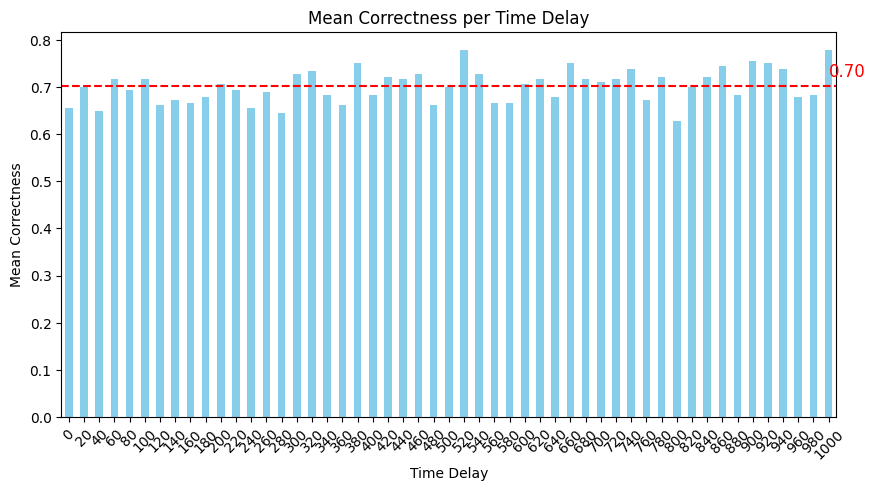

In [6]:
# Group by ID and calculate the mean correctness
mean_correctness = final_df.groupby("isi_ms")["correct"].mean()

# Calculate the mean of the means
mean_of_means = mean_correctness.mean()

# Plot the means of correctness for each participant
plt.figure(figsize=(10, 5))
mean_correctness.plot(kind="bar", color="skyblue")
plt.axhline(mean_of_means, color="red", linestyle="--", label=f"Mean of Means: {mean_of_means:.2f}")
plt.text(len(mean_correctness) - 1, mean_of_means + 0.02, f"{mean_of_means:.2f}", color="red", fontsize=12)

#plt.title("Mean Correctness per Participant (ID) - Our Data")
plt.title("Mean Correctness per Time Delay")
#plt.xlabel("Participant ID")
plt.xlabel("Time Delay")
plt.ylabel("Mean Correctness")
plt.xticks(rotation=45)
plt.savefig(root_dir + '/plots/with006/mean_correctness_per_time_delay.png', bbox_inches="tight")
plt.show()

In [ ]:
### Set the parameters of the GLM-HMM
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2  #3      # input dimensions #change_for_adding_bias
N_iters = 500

In [8]:
inpts = []
choices = []
participants = final_df["ID"].unique()

for load_idx in participants:
    this_data = final_df.loc[final_df['ID'] == load_idx].copy()
        ## start with estimating the experiment as a whole
    num_sess = 1
    num_trials_per_sess = len(this_data)

    new_inpts = []
    new_choices = []

    new_inpts = np.ones((num_trials_per_sess, input_dim))
    
    ## get input format
    new_inpts[:, 0] = this_data['theta'].copy()
    new_inpts[:, 1] = this_data['prev_resp'].copy()
    #new_inpts[:, 2] = this_data['previous_contrast'].copy()
    #new_inpts[:, 2] = np.ones(this_data.shape[0])
    inpts.append(new_inpts)

    new_choices = this_data['resp'].copy()
    new_choices = np.atleast_2d(new_choices).T
    choices.append(new_choices) 

## Fit at group-level in one-state GLM-HMM

In [9]:
### fit one state GLM-HMM at group level

num_states = 1
n_iter = 100

transition_alpha = 1
prior_sigma = 10

iter_array = np.full([n_iter, 2], np.nan)
#iter_array = np.full([n_iter, 3], np.nan) #change_for_adding_bias
for idx in range(n_iter):
    
    one_state_glmhmm = HMM(num_states, obs_dim, input_dim, 
                    observations="input_driven_obs", 
                    observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                    transitions="sticky", 
                    transition_kwargs=dict(alpha=transition_alpha, kappa=0))
    print(one_state_glmhmm.params)
    one_state_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)
    iter_array[idx,] = one_state_glmhmm.observations.params.reshape((1,2))
    #iter_array[idx,] = one_state_glmhmm.observations.params.reshape((1,3)) #change_for_adding_bias


((array([-0.]),), (array([[0.]]),), array([[[0.74159174, 1.55291372]]]))
((array([-0.]),), (array([[0.]]),), array([[[ 1.86755799, -0.97727788]]]))
((array([-0.]),), (array([[0.]]),), array([[[ 1.26611853, -0.50587654]]]))
((array([-0.]),), (array([[0.]]),), array([[[0.76103773, 0.12167502]]]))
((array([-0.]),), (array([[0.]]),), array([[[0.48431215, 0.57914048]]]))
((array([-0.]),), (array([[0.]]),), array([[[ 1.49407907, -0.20515826]]]))
((array([-0.]),), (array([[0.]]),), array([[[-0.96075461,  0.37692697]]]))
((array([-0.]),), (array([[0.]]),), array([[[-2.55298982,  0.6536186 ]]]))
((array([-0.]),), (array([[0.]]),), array([[[-0.24214951,  1.51439128]]]))
((array([-0.]),), (array([[0.]]),), array([[[ 0.04575852, -0.18718385]]]))
((array([-0.]),), (array([[0.]]),), array([[[0.56644004, 0.14926509]]]))
((array([-0.]),), (array([[0.]]),), array([[[-0.88778575, -1.98079647]]]))
((array([-0.]),), (array([[0.]]),), array([[[ 0.17538653, -0.46250554]]]))
((array([-0.]),), (array([[0.]]),

In [12]:
#df_iter_array = pd.DataFrame(iter_array, columns = ['theta', 'prev_resp', 'bias']) #change_for_adding_bias
df_iter_array = pd.DataFrame(iter_array, columns = ['theta', 'prev_resp'])
if save_data:
    df_iter_array.to_csv(root_dir + '/HMM/withoutbias/one_level_HMM_params.csv', index = False) 

In [13]:
df_iter_array = pd.read_csv(root_dir + '/HMM/withoutbias/one_level_HMM_params.csv')
params_for_initalization = df_iter_array.mean().values
print(params_for_initalization)

[-0.87123841 -0.29061449]


# Fit multi-state GLM-HMMs at group-level and compare BIC

In [14]:
## compare models based on BIC
max_num_states =  2    # number of discrete states

N_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
# Make a GLM-HMM
prior_sigma = 10
transition_alpha = 1

BIC = []
for state_idx in range(max_num_states): 
    print(state_idx)
    compare_glmhmm = HMM(state_idx+1, obs_dim, input_dim, 
                    observations="input_driven_obs", 
                    observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                    transitions="sticky", 
                    transition_kwargs=dict(alpha=transition_alpha, kappa=0))

    
    _ = compare_glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)
    n_total_params = np.concatenate(compare_glmhmm.observations.params).size + np.concatenate(compare_glmhmm.transitions.params).size
    
    # Flatten choices and inpts to calculate log likelihood correctly
    flattened_choices = np.concatenate(choices)
    flattened_inpts = np.concatenate(inpts)

    new_BIC = np.log(np.size(flattened_choices))*n_total_params - 2*compare_glmhmm.log_likelihood(choices, inputs=inpts)
    
    if save_data:
        pd.DataFrame(np.append(new_BIC, np.concatenate(compare_glmhmm.observations.params))).to_csv(root_dir + '/HMM/withoutbias/Full_model_outcome_states_' + str(state_idx + 1) + '.csv', index = False)

    BIC = np.append(BIC, new_BIC) 
    print(compare_glmhmm.observations.params)

df_BIC = pd.DataFrame({'BIC': BIC, 'num_states': np.arange(max_num_states) + 1})


if save_data:
    df_BIC.to_csv(root_dir + '/HMM/withoutbias/BIC_across_models.csv', index = False)


0
[[[-0.8712094  -0.29061204]]]
1
[[[-1.73583337 -4.1863664 ]]

 [[-0.97571119  0.05285255]]]


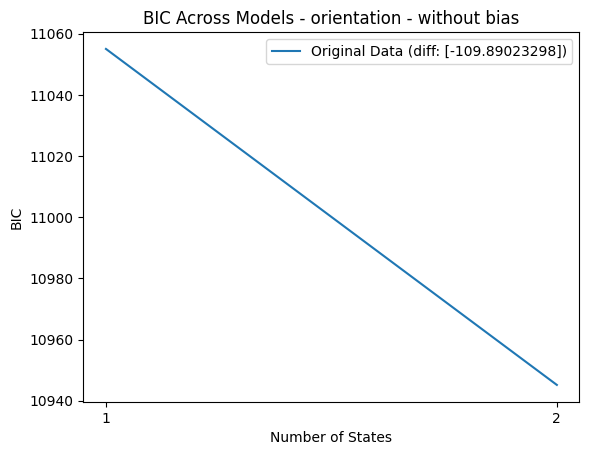

In [15]:
df_BIC = pd.read_csv(root_dir + '/HMM/withoutbias/BIC_across_models.csv')
bic_diff = np.diff(df_BIC.BIC)

plt.plot(df_BIC['num_states'], df_BIC['BIC'], label=f'Original Data (diff: {bic_diff})')
plt.title('BIC Across Models - orientation - without bias') #change_for_adding_bias
plt.xlabel('Number of States')
plt.ylabel('BIC')
plt.legend()
plt.xticks([1, 2])
plt.savefig(root_dir + '/plots/withoutbias/BIC_across_models_orientation.png', bbox_inches='tight')
plt.show()

# Fit permuted multi-state GLM-HMMs at group-level and compare BIC

In [16]:
# Permutation analysis
n_perm = 100
BIC_permuted = []

for perm_idx in range(n_perm):
    permuted_choices = []
    permuted_inpts = []
    
    for i in range(len(choices)):
        perm_indices = np.random.permutation(choices[i].shape[0])
        permuted_choices.append(choices[i][perm_indices])
        permuted_inpts.append(inpts[i][perm_indices])
    
    for state_idx in range(max_num_states):
        print(f"Permutation {perm_idx}, State {state_idx}")
        permuted_glmhmm = HMM(state_idx + 1, obs_dim, input_dim, 
                                  observations="input_driven_obs", 
                                  observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                                  transitions="sticky", 
                                  transition_kwargs=dict(alpha=transition_alpha, kappa=0))

        _ = permuted_glmhmm.fit(permuted_choices, inputs=permuted_inpts, method="em", num_iters=N_iters, initialize=True, tolerance=10**-4, verbose=False)

        n_total_params = np.concatenate(permuted_glmhmm.observations.params).size + np.concatenate(permuted_glmhmm.transitions.params).size

        # Compute log likelihood
        log_likelihood = permuted_glmhmm.log_likelihood(permuted_choices, inputs=permuted_inpts)

        # Compute BIC
        new_BIC = np.log(len(flattened_choices)) * n_total_params - 2 * log_likelihood
        BIC_permuted.append({'perm_idx': perm_idx, 'state_idx': state_idx + 1, 'BIC': new_BIC})

df_BIC_permuted = pd.DataFrame(BIC_permuted)
if save_data:
    df_BIC_permuted.to_csv(root_dir + '/HMM/withoutbias/BIC_permuted_across_models.csv', index=False)

Permutation 0, State 0
Permutation 0, State 1
Permutation 1, State 0
Permutation 1, State 1
Permutation 2, State 0
Permutation 2, State 1
Permutation 3, State 0
Permutation 3, State 1
Permutation 4, State 0
Permutation 4, State 1
Permutation 5, State 0
Permutation 5, State 1
Permutation 6, State 0
Permutation 6, State 1
Permutation 7, State 0
Permutation 7, State 1
Permutation 8, State 0
Permutation 8, State 1
Permutation 9, State 0
Permutation 9, State 1
Permutation 10, State 0
Permutation 10, State 1
Permutation 11, State 0
Permutation 11, State 1
Permutation 12, State 0
Permutation 12, State 1
Permutation 13, State 0
Permutation 13, State 1
Permutation 14, State 0
Permutation 14, State 1
Permutation 15, State 0
Permutation 15, State 1
Permutation 16, State 0
Permutation 16, State 1
Permutation 17, State 0
Permutation 17, State 1
Permutation 18, State 0
Permutation 18, State 1
Permutation 19, State 0
Permutation 19, State 1
Permutation 20, State 0
Permutation 20, State 1
Permutation 

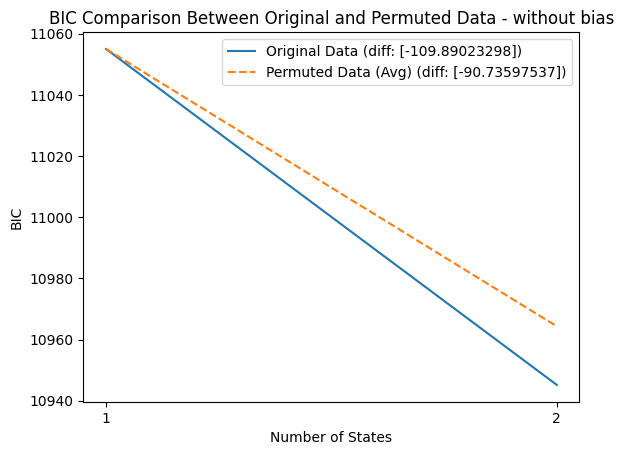

In [17]:
# Average BIC across permutations
df_BIC_permuted_avg = df_BIC_permuted.groupby('state_idx').agg({'BIC': 'mean'}).reset_index()
bic_diff = np.diff(df_BIC['BIC'])
bic_diff_permuted = np.diff(df_BIC_permuted_avg['BIC'])

# Plotting
plt.plot(df_BIC['num_states'], df_BIC['BIC'], label=f'Original Data (diff: {bic_diff})')
plt.plot(df_BIC_permuted_avg['state_idx'], df_BIC_permuted_avg['BIC'], label=f'Permuted Data (Avg) (diff: {bic_diff_permuted})', linestyle='--')
plt.xlabel('Number of States')
plt.ylabel('BIC')
plt.legend()
plt.title('BIC Comparison Between Original and Permuted Data - without bias') #change_for_adding_bias
plt.xticks([1, 2])
plt.savefig(root_dir + '/plots/withoutbias/BIC_comparison_orientation.png', bbox_inches='tight')
plt.show()

# Fit two-state GLM-HMMs 

In [ ]:
npr.seed(0)
# Set the parameters of the GLM-HMM
num_states =  2      # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2 #3      # input dimensions #change_for_adding_bias

N_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
# Make a GLM-HMM

prior_sigma = 10
transition_alpha = 1

n_iter = 10
parameters_ext_int = np.full([n_iter, 8], np.nan)
#parameters_ext_int = np.full([n_iter, 10], np.nan) #change_for_adding_bias
for idx in range(n_iter):
    print(idx)
    glmhmm = HMM(num_states, obs_dim, input_dim, 
                        observations="input_driven_obs", 
                        observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                        transitions="sticky", 
                        transition_kwargs=dict(alpha=transition_alpha, kappa=0))
    
    #glmhmm.observations.params =  np.tile(params_for_initalization, (num_states,1)).reshape(num_states, 1, 2) #change_for_adding_bias #2->3
    _ = glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = True, tolerance=10**-4, verbose = False)
   
    index_ext = np.argmax(np.concatenate(-glmhmm.observations.params)[:,0])
    index_int = np.argmin(np.concatenate(-glmhmm.observations.params)[:,0])
    parameters_ext_int[idx,] = np.concatenate((-glmhmm.observations.params[index_ext,:], -glmhmm.observations.params[index_int,:], glmhmm.transitions.params[0].reshape(1,4)), axis = 1)
    del(glmhmm)


0
1
2
3
4
5
6
7
8
9


en gros, ext c'est pour la phase externale, int pour la phase internale où les coefs sont moins importants

In [47]:

df_two_state_init = pd.DataFrame(parameters_ext_int, columns = ['orientation_ext', 'prev_resp_ext',
                                                                'orientation_int', 'prev_resp_int',
                                                                 'AA', 'AB', 'BA', 'BB']) #change_for_adding_bias


In [20]:
if save_data:
    df_two_state_init.to_csv(root_dir + '/HMM/withoutbias/two_state_init_param.csv', index = False)

In [21]:
df_two_state_init = pd.read_csv(root_dir + '/HMM/withoutbias/two_state_init_param.csv')

In [48]:
df_two_state_init.mean()

orientation_ext    1.178026
prev_resp_ext      1.009058
orientation_int    0.484662
prev_resp_int      0.401297
AA                -0.039367
AB                -6.475079
BA                -6.432487
BB                -0.039403
dtype: float64

In [49]:
print(np.exp(df_two_state_init.mean()['orientation_ext'])/np.exp(df_two_state_init.mean()['prev_resp_ext']) )
print(np.exp(df_two_state_init.mean()['orientation_int'])/np.exp(df_two_state_init.mean()['prev_resp_int']) )

1.1840824164473533
1.0869391910553285


In [ ]:
df_two_state_init = pd.read_csv(root_dir + '/HMM/withoutbias/two_state_init_param.csv')
param_init_ext_int = df_two_state_init.mean().values

recovered_weights = -param_init_ext_int[0:4].reshape(2,1,2)    
recovered_trans_mat = np.exp(param_init_ext_int[4:8].reshape(2,2))     
#recovered_weights = -param_init_ext_int[0:6].reshape(2,1,3)         #change_for_adding_bias
#recovered_trans_mat = np.exp(param_init_ext_int[6:10].reshape(2,2)) #change_for_adding_bias


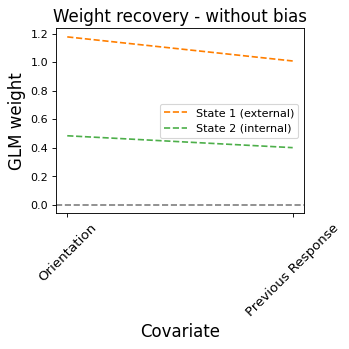

In [ ]:
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8',  '#8B0000', '#000000']
for k in range(num_states):
    if k==0:
        plt.plot(range(input_dim), -recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = "State 1 (external)", linestyle = '--') #State 1 (70o-30pr)
    else:
        plt.plot(range(input_dim), -recovered_weights[k][0], color=cols[k],
                     lw=1.5,  label = 'State 2 (internal)', linestyle = '--') #State 2 (10o-90pr)
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("Covariate", fontsize=15)
#plt.xticks([0, 1, 2], ['Orientation', 'Previous Response', 'Bias'], fontsize=12, rotation=45) #change_for_adding_bias
plt.xticks([0, 1], ['Orientation', 'Previous Response'], fontsize=12, rotation=45) 
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Weight recovery - without bias", fontsize=15)
plt.savefig(root_dir + '/plots/withoutbias/weight_recovery_orientation.png', bbox_inches='tight')
plt.show()

on voit que la previous response n'a pas de poids dans le state n1.

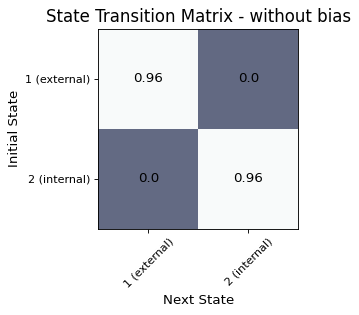

In [ ]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1 (external)', '2 (internal)'), fontsize=10, rotation=45)
plt.yticks(range(0, num_states), ('1 (external)', '2 (internal)'), fontsize=10) #'1 (70o-30pr)', '2 (10o-90pr)'
plt.ylim(num_states - 0.5, -0.5)
plt.xlabel('Next State', fontsize=12)
plt.ylabel('Initial State', fontsize=12)
plt.title("State Transition Matrix - without bias", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig(root_dir + '/plots/withoutbias/transitions_orientation.png', bbox_inches='tight')
plt.show()

## Posterior State Probabilities

Let's now plot $p(z_{t} = k|\mathbf{y}, \{u_{t}\}_{t=1}^{T})$, the posterior state probabilities, which give the probability of the animal being in state k at trial t.

In [53]:
# run average model
prior_sigma = 10

glmhmm = HMM(num_states, obs_dim, input_dim, 
                        observations="input_driven_obs", 
                        observation_kwargs=dict(C=num_categories, prior_sigma=prior_sigma), 
                        transitions="sticky", 
                        transition_kwargs=dict(alpha=transition_alpha, kappa=0))
        
glmhmm.init_state_distn.params = np.log([0.5, 0.5])
glmhmm.observations.params = -param_init_ext_int[0:4].reshape(2,1,2)
glmhmm.transitions.params = (param_init_ext_int[4:8].reshape(2,2),)

#glmhmm.init_state_distn.params = np.log([0.5, 0.5, 0.5]) #change_for_adding_bias
#glmhmm.observations.params = -param_init_ext_int[0:6].reshape(2,1,3)
#glmhmm.transitions.params = (param_init_ext_int[6:10].reshape(2,2),)

_ = glmhmm.fit(choices, inputs=inpts, method="em", num_iters=N_iters, initialize = False, tolerance=10**-4, verbose = False)
print(-glmhmm.observations.params)
index_ext = np.argmax(np.concatenate(-glmhmm.observations.params)[:,0])
index_int = np.argmin(np.concatenate(-glmhmm.observations.params)[:,0])

[[[1.0389273  0.21750762]]

 [[0.36281908 0.51343971]]]


In [54]:
# Get expected states:
posterior_probs = [glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(choices, inpts)]

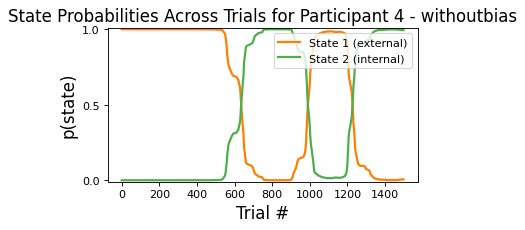

In [ ]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
sess_id = 3 #session id; can choose any index between 0 and num_sess-1=6-1=5
for k in range(num_states):
    if k==0:
        plt.plot(posterior_probs[sess_id][1:1500, k], label="State 1 (external)", lw=2, #State 1 (36%)
             color=cols[k])
    else:
        plt.plot(posterior_probs[sess_id][1:1500, k], label="State 2 (internal)", lw=2, #State 2 (64%)
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("Trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)
plt.legend(loc="upper right", fontsize=10, title_fontsize=12)
plt.title(f"State Probabilities Across Trials for Participant {sess_id+1} - withoutbias", fontsize=15)
#plt.title(f"State Probabilities Across Trials - test", fontsize=15)
plt.savefig(root_dir + '/plots/withoutbias/probabilities_orientation_004.png', bbox_inches='tight')
plt.show()

With these posterior state probabilities, we can assign trials to states and then plot the fractional occupancy of each state:

In [56]:
# concatenate posterior probabilities across sessions
posterior_probs_concat = np.concatenate(posterior_probs)
# get state with maximum posterior probability at particular trial:
state_max_posterior = np.argmax(posterior_probs_concat, axis = 1)
# now obtain state fractional occupancies:
_, state_occupancies = np.unique(state_max_posterior, return_counts=True)
state_occupancies = state_occupancies/np.sum(state_occupancies)

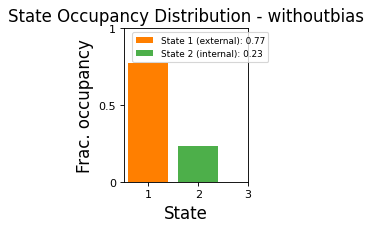

In [ ]:
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
for z, occ in enumerate(state_occupancies):
    if z==0:
        plt.bar(z, occ, width = 0.8, color = cols[z], label=f'State 1 (external): {occ:.2f}') #State 1 (36%)
    else:
        plt.bar(z, occ, width = 0.8, color = cols[z], label=f'State 2 (internal): {occ:.2f}') #State 2 (64%)

plt.ylim((0, 1))
plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize = 10)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
plt.xlabel('State', fontsize = 15)
plt.ylabel('Frac. occupancy', fontsize=15)
plt.legend(loc="upper right", fontsize=8, title_fontsize=10, bbox_to_anchor=(1.2, 1))
plt.title("State Occupancy Distribution - withoutbias", fontsize=15)
plt.savefig(root_dir + '/plots/withoutbias/fraction_occupancy_orientation.png', bbox_inches='tight')
plt.show()

In [35]:
final_df = final_df.assign(Gl_Prob_State_ext = posterior_probs_concat[:,index_ext])
final_df = final_df.assign(Gl_Prob_State_int = posterior_probs_concat[:,index_int])

if save_data:
    #final_df.to_csv(root_dir + f'/Full_Data/Full_Data_test_model_{fraction_odd * 100:.0f}.csv', index = False)
    final_df.to_csv(root_dir + f'/Full_Data/Full_Data_withoutbias.csv', index = False)